In [1]:
%matplotlib inline
import matplotlib
import random
import torch
from d2l import torch as d2l
# 内嵌画图
# %matplotlib inline
# import matplotlib # 注意这个也要import一次
# import matplotlib.pyplot as plt
# myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/方正粗黑宋简体.ttf') # 这一行
# plt.plot((1,2,3),(4,3,-1))
# plt.xlabel(u'横坐标',  fontproperties=myfont) # 这一段
# plt.ylabel(u'纵坐标',  fontproperties=myfont) # 这一段
# #plt.show() # 有了%matplotlib inline 就可以省掉plt.show()了

def synthetic_data(w, b, num_example):  #@save
    X = torch.normal(0,  1, (num_example, len(w)))  #均值为0 方差为1随机数
    Y = torch.matmul(X, w) +b   #matmul 乘法运算
    Y += torch.normal(0, 0.01, Y.shape) #加入随机噪音
    return X, Y.reshape((-1,1))

In [2]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.3866, -0.0798]) 
label: tensor([5.2691])


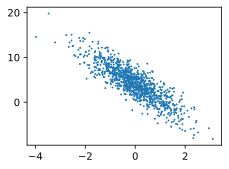

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, Y in data_iter(batch_size, features, labels):
    print(X, '\n', Y)
    break

tensor([[-0.5251,  1.1343],
        [-1.5770, -3.9788],
        [-0.3023, -2.0301],
        [ 0.8507,  0.0577],
        [-1.1179,  0.4541],
        [-1.1932,  1.3109],
        [ 1.1515, -2.0863],
        [-0.8423, -0.1925],
        [-0.3310,  0.0561],
        [ 1.7360, -1.7086]]) 
 tensor([[-0.7076],
        [14.5771],
        [10.4938],
        [ 5.7049],
        [ 0.4184],
        [-2.6440],
        [13.5931],
        [ 3.1760],
        [ 3.3623],
        [13.4837]])


## 初始化模型参数


In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。

In [9]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

In [10]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041658
epoch 2, loss 0.000168
epoch 3, loss 0.000053
epoch 4, loss 0.000052
epoch 5, loss 0.000052


In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)
